In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import random

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

from mtcnn.mtcnn import MTCNN

0it [00:00, ?it/s]

In [2]:
PATH = 'E:\\faces\\train\\ben_afflek\\'

ROOT_PATH = 'E:\\faces\\'

TRAIN_PATH = 'E:\\faces\\train\\'

VAL_PATH = 'E:\\faces\\val\\'

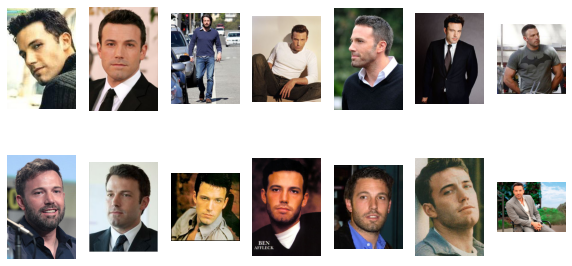

In [3]:
plt.figure(figsize=(10,5))
for i, filename in enumerate(os.listdir(PATH)):
    path = PATH + filename
    image = plt.imread(path)
    
    plt.subplot(2, 7, i+1)
    
    plt.axis('off')
    plt.imshow(image)
    
plt.show()

In [ ]:
# Detect Faces using MTCNN

0it [00:00, ?it/s]

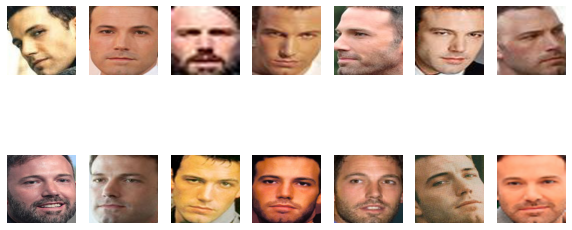

In [4]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    
    x2, y2 = x1 + width, y1 + height
    
    face = pixels[y1:y2, x1:x2]
    
    image = Image.fromarray(face)
    
    image = image.resize(required_size)
    face_array = np.asarray(image)
    
    return face_array

plt.figure(figsize=(10,5))
for i, filename in tqdm(enumerate(os.listdir(PATH))):
    path = PATH + filename
    
    face = extract_face(path)
    
    #print(i+1, face.shape)
    
    plt.subplot(2, 7, i+1)
    
    plt.axis('off')
    plt.imshow(face)
    
plt.show()

In [ ]:
# Load Faces

In [5]:
def load_faces(directory):
    faces = list()
    for file_name in tqdm(os.listdir(directory)):
        path = directory + file_name
        face = extract_face(path)
        
        faces.append(face)
    return faces

def load_dataset(directory):
    images, labels = list(), list()
    for folder in tqdm(os.listdir(directory)):
        path = directory + folder + '/'
        
        if not os.path.isdir(path):
            continue
        
        faces = load_faces(path)

        print(f'Celebrity : {folder}, Faces : {len(faces)}')

        label = [folder for _ in range(len(faces))]

        images.extend(faces)
        labels.extend(label)
        
    return np.asarray(images), np.asarray(labels)

In [6]:
X_train, y_train = load_dataset(TRAIN_PATH)

X_test, y_test = load_dataset(VAL_PATH)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Celebrity : ben_afflek, Faces : 14


  0%|          | 0/17 [00:00<?, ?it/s]

Celebrity : elton_john, Faces : 17


  0%|          | 0/21 [00:00<?, ?it/s]

Celebrity : jerry_seinfeld, Faces : 21


  0%|          | 0/19 [00:00<?, ?it/s]

Celebrity : madonna, Faces : 19


  0%|          | 0/22 [00:00<?, ?it/s]

Celebrity : mindy_kaling, Faces : 22


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Celebrity : ben_afflek, Faces : 5


  0%|          | 0/5 [00:00<?, ?it/s]

Celebrity : elton_john, Faces : 5


  0%|          | 0/5 [00:00<?, ?it/s]

Celebrity : jerry_seinfeld, Faces : 5


  0%|          | 0/5 [00:00<?, ?it/s]

Celebrity : madonna, Faces : 5


  0%|          | 0/5 [00:00<?, ?it/s]

Celebrity : mindy_kaling, Faces : 5


In [ ]:
# Create Face Embeddings

In [7]:
face_pixels = X_train[0]

print(face_pixels.shape)

face_pixels = np.expand_dims(face_pixels, axis=0)
print(face_pixels.shape)

(160, 160, 3)
(1, 160, 160, 3)


In [ ]:
from keras.models import load_model

def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    
    # standardize pixel values across channels (global) 
    mean, std = face_pixels.mean(), face_pixels.std() 
    face_pixels = (face_pixels - mean) / std
    
    samples = np.expand_dims(face_pixels, axis=0)
    
    yhat = model.predict(samples)
    
    return yhat[0]

model = load_model('/kaggle/input/keras-facenet/facenet_keras.h5')


trainX = list()

for pixels in tqdm(X_train):
    embedding = get_embedding(model, pixels)
    trainX.append(embedding)
trainX = np.asarray(trainX)

print('Train X :', trainX.shape)


testX = list()

for pixels in tqdm(X_test):
    embedding = get_embedding(model, pixels)
    testX.append(embedding)
testX = np.asarray(testX)

print('test X :', testX.shape)